# 🐶 End-to-End Multi-Class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitiing at a cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set
(these images have labels)
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [1]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version:  2.13.0
TF Hub version:  0.14.0
GPU available (YESSSS!!!!)


In [2]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [3]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: xlabel='breed'>

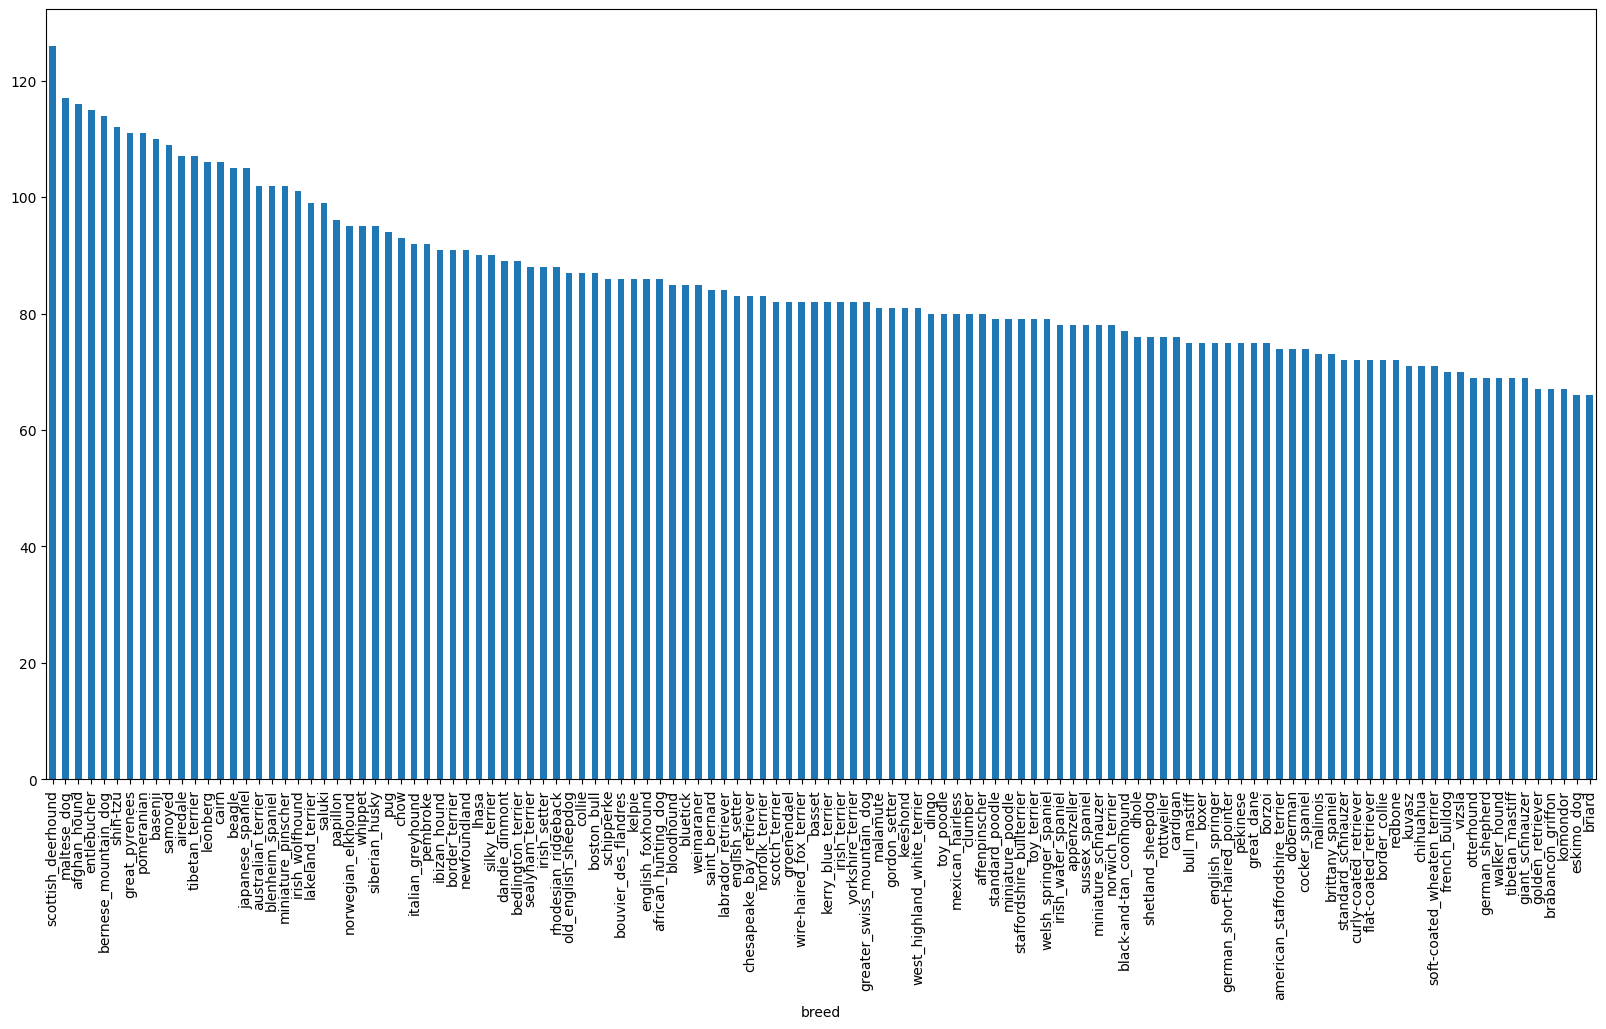

In [4]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize = (20, 10))

In [5]:
labels_csv["breed"].value_counts().median()

82.0

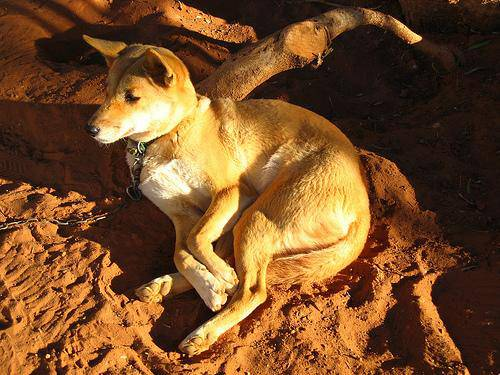

In [6]:
# Let's view an image
from IPython.display import Image
Image('data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

### Getting images and their labels

Let's get a list of all of our image file pathnames.

In [7]:
# Create pathnames from image ID's
filenames = ["data/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [8]:
import os
os.listdir("data/train/")[:10]

['84accc2dc9f5bb3ebee89fe1bf23639c.jpg',
 '14cffe576239620f1733dfe487dbaa6f.jpg',
 'cc93915e06bc55626a02af95006a48c2.jpg',
 '6f9bac41b5be5ee6baecc9e7ef8f2c2a.jpg',
 '64dd586a1d08937d20618233df2e5dbc.jpg',
 '2c1b06c76751d8b9f9ff943cd693cfca.jpg',
 '114524d11fe49af5be43897233a4f65e.jpg',
 'efec2f66576df7aa036d77ad1fafc8bf.jpg',
 'eecab13ff6ae86429d808115d161d455.jpg',
 '30d54cbd3a88a8473ade8028cd1f2378.jpg']

In [9]:
# Check wheteher number of filenames matches number of actual image files
import os
if len(os.listdir("data/train/")) == len(filenames):
    print("Filenames match actual amount of files!!! Proceed.")
else:
    print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed.


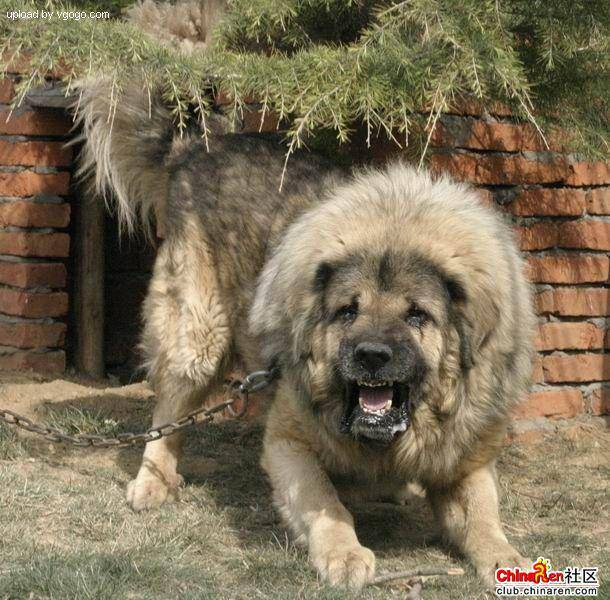

In [10]:
# One more check
Image(filenames[9000])

In [11]:
labels_csv['breed'][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [12]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [13]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
    print("Number of labels matches number of filenames!")
else:
    print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [14]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [15]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:1]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False])]

In [17]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # Index where label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [18]:
filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [19]:
# Setup X & y variables
X = filenames
y = boolean_labels

We're going to start off experimenting ~1000 images and increase as needed.

In [20]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min: 1000, max: 10000, step: 1000}

In [21]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_valid, y_train, y_valid = train_test_split(X[:NUM_IMAGES],
                                                      y[:NUM_IMAGES],
                                                      test_size = 0.2,
                                                      random_state = 42)
len(X_train), len(X_valid), len(y_train), len(y_valid)

(800, 200, 800, 200)

In [22]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False

## Preprocessing images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image file path as input 
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel value form 0-255 to 0-1).
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`.

Before we do, let's see what importing an image looks like.

In [23]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [24]:
image

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]

In [25]:
image.max(), image.min()

(255, 0)

In [26]:
# Turn image into a tensor
tf.constant(image)[:2]

2023-08-21 16:43:42.717787: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-21 16:43:42.717807: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-21 16:43:42.717814: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-21 16:43:42.718035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-21 16:43:42.718063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.
1. Take an image file path as input 
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel value form 0-255 to 0-1).
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`.

In [27]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
    """
    Takes an image file path and turns the image into a Tensor.
    """
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpg image into numerical Tensor 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels = 3)
    # Convert the colour channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (224, 224)
    image = tf.image.resize(image, size = [img_size, img_size])
    
    return image

## Turning our data into batches

Why turn our data into batches?

Let's say you'retrying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 images (batch size) at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(image, label)`

In [28]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the associated label, 
    processes the image and returns a tuple of (image, label).
    """
    image = process_image(image_path)
    return image, label

In [29]:
# Demo of the above
print(get_image_label(X[42], y[42]))
# (process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.2389375 ],
        ...,
        [0.29325107, 0.5189916 , 0.32155466],
        [0.29721776, 0.52466875, 0.33030325],
        [0.2948505 , 0.5223015 , 0.3340662 ]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]],

       [[0.20941195, 0.40692955, 0.25792548],
        [0.24045378, 0.43900946, 0.2868911 ],
        [0.29001117, 0.47937486, 0.32247737],
        ...,
        [0.26074055, 0.48414773, 0.30125174],
        [0.27101526, 0.49454468, 0.32096273],
        [0.27939945, 0.5029289 , 0.32934693]],

       ...,

       [[0.00634811, 0.03442093, 0.02581115],
        [0.0

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches!

In [30]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data, but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only filepaths (no labels)
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch
    
    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # Filepaths
                                                   tf.constant(y))) # Labels
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch
    
    else:
        print("Creating train data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size = len(X))
        
        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)
        
        # Turn the training data into batches
        data_batch = data.batch(batch_size)
        
    return data_batch
        

In [31]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid, valid_data = True)

Creating train data batches...
Creating validation data batches...


In [32]:
# Check out the different attributes of our data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however these can be a little hard to understand/comprehend, let's visualize them!

In [33]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch.
    """
    # Setup the figure
    plt.figure(figsize = (10, 10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i + 1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis("off")
        

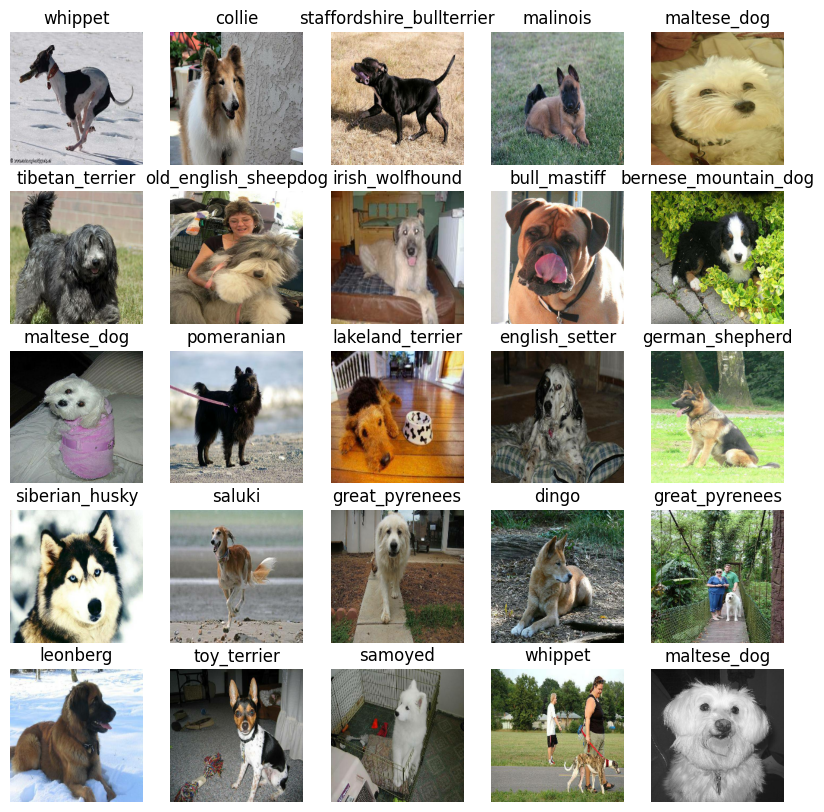

In [34]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

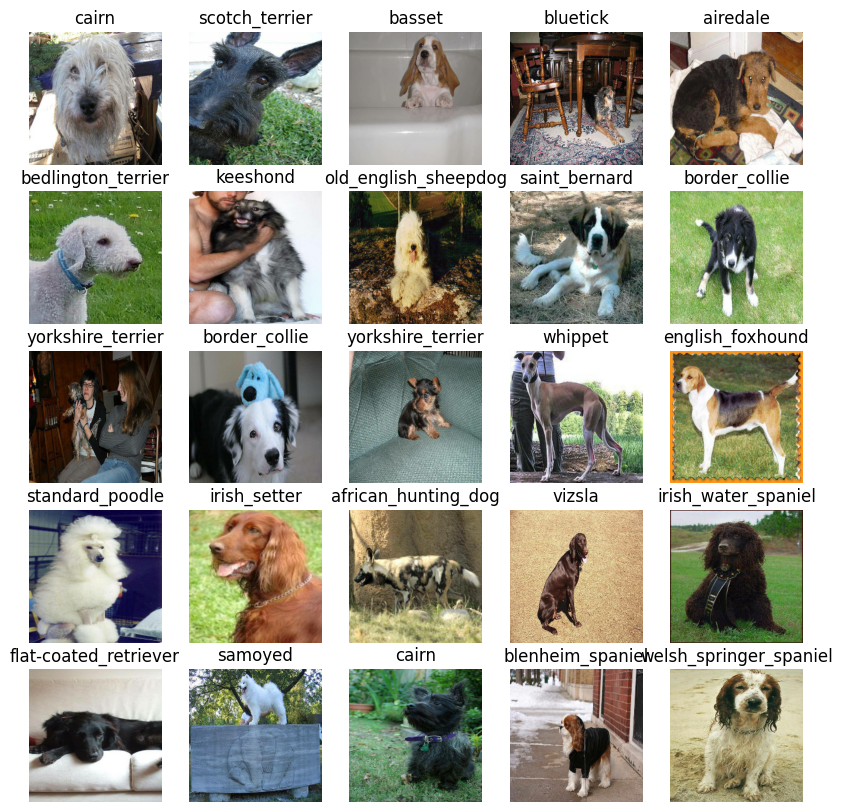

In [35]:
# Now let's visualize our validation set
valid_images, valid_labels = next(valid_data.as_numpy_iterator())
show_25_images(valid_images, valid_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the from of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [36]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # Batch, Height, Width, Color Channels

# Setup the output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5'

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [37]:
# Create a function which builds a Keras model
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
    print("BUilding model with: ", model_url)
    
    # Setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url), # Layer 1 (input Layer)
        tf.keras.layers.Dense(units = output_shape,
                              activation = 'softmax') # Layer 2 (Output Layer)
    ])
    
    # Compile the model
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.legacy.Adam(),
        metrics = ['accuracy']
    )
    
    # Build the model
    model.build(input_shape)
    
    return model

In [38]:
model = create_model()
model.summary()

BUilding model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [39]:
outputs = np.ones(shape = (1, 1, 1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create 2 callbacks, one for TensorBoard which helps track our models progress and another for early stopping, which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback, which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs `tensorboard` magic function (we'll do this after model training).

In [40]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [41]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join("logs",
                           # Make it so the logs get tracked everytime we run an experiment
                           datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting, by stopping traing if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [42]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                  patience = 3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [43]:
NUM_EPOCHS = 100 #@param {type: "slider", min: 10, max: 100, step: 10}

In [44]:
# Check to make sure we're still running on a GPU
print("GPU", "available (YEEEESSSS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YEEEESSSS!!!!)


Let's create a function which trains a model.
* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochsto train for (`NUM_EPOCHS`) and the callbacks we'd like to use.
* Return the model.


In [45]:
# Build a function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()
    
    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()
    
    # Fit the model to the data passing it the callbacks we created
    model.fit(x = train_data,
              epochs = NUM_EPOCHS,
              validation_data = valid_data,
              validation_freq = 1,
              callbacks = [tensorboard, early_stopping])
    
    # Return the fitted model
    return model

In [46]:
# Fit the model to the data
model = train_model()

BUilding model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100


2023-08-21 16:43:47.396988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 4.6630 - accuracy: 0.0800

2023-08-21 16:43:50.087089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 5s 125ms/step - loss: 4.6630 - accuracy: 0.0800 - val_loss: 3.3438 - val_accuracy: 0.2750
Epoch 2/100
25/25 [==============================] - 2s 91ms/step - loss: 1.6966 - accuracy: 0.6662 - val_loss: 2.0842 - val_accuracy: 0.5350
Epoch 3/100
25/25 [==============================] - 4s 174ms/step - loss: 0.5852 - accuracy: 0.9388 - val_loss: 1.5994 - val_accuracy: 0.6000
Epoch 4/100
25/25 [==============================] - 2s 92ms/step - loss: 0.2588 - accuracy: 0.9862 - val_loss: 1.4314 - val_accuracy: 0.6350
Epoch 5/100
25/25 [==============================] - 2s 95ms/step - loss: 0.1484 - accuracy: 0.9950 - val_loss: 1.3472 - val_accuracy: 0.6500
Epoch 6/100
25/25 [==============================] - 2s 92ms/step - loss: 0.1024 - accuracy: 1.0000 - val_loss: 1.2919 - val_accuracy: 0.6750
Epoch 7/100
25/25 [==============================] - 2s 89ms/step - loss: 0.0763 - accuracy: 1.0000 - val_loss: 1.2700 - val_accuracy: 0.6900
Epoch 8/100
25/2

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing! It means our model is learning!!!

### Checking the Tensorboard logs

The TenorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualizeit's contents.

In [47]:
%tensorboard --logdir logs/

## Making and evaluating predictions using a trained model

In [48]:
# make predictions on the validation data (not used to train on)
predictions = model.predict(valid_data, verbose = 1)
predictions

2023-08-21 16:44:26.155118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 2s 131ms/step


array([[4.31822875e-04, 2.14540632e-05, 6.47873851e-03, ...,
        1.96148688e-03, 6.74138300e-06, 1.53545674e-03],
       [2.73654424e-03, 2.15527602e-03, 1.27768843e-02, ...,
        5.10839513e-04, 1.17219496e-03, 1.93338608e-04],
       [4.23755637e-06, 1.32976056e-04, 2.97307106e-05, ...,
        1.32989944e-05, 2.99722774e-06, 2.02392293e-05],
       ...,
       [7.79506422e-07, 6.89389435e-06, 2.53952112e-05, ...,
        1.86421694e-05, 1.32333162e-05, 1.18522839e-05],
       [2.99819675e-03, 8.10463898e-05, 2.22389790e-04, ...,
        2.65170529e-04, 3.21457446e-05, 1.53689813e-02],
       [6.04618399e-04, 1.49235011e-05, 2.21033511e-03, ...,
        1.48205925e-02, 2.70384783e-03, 1.41041935e-04]], dtype=float32)

In [49]:
predictions.shape

(200, 120)

In [50]:
len(y_valid)

200

In [51]:
# First Prediction
index = 42
print(predictions[index])
print(f"Max Value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max Index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.50557767e-04 8.86230482e-05 1.77608294e-04 2.05969496e-04
 4.23062081e-03 4.06418949e-05 5.66771123e-05 1.10337674e-03
 1.18252113e-02 3.36655974e-02 1.06087373e-05 1.06479529e-05
 5.13841573e-04 7.32084597e-03 2.95592914e-03 5.24897501e-03
 4.03322374e-05 3.85835912e-04 4.19696531e-04 1.46391278e-04
 2.94790025e-05 1.52113731e-03 2.25871645e-05 2.57945158e-05
 2.65939534e-02 2.11039296e-05 6.52117524e-05 1.97129135e-04
 4.33778012e-04 1.97767658e-04 3.03586057e-05 7.01009849e-05
 4.56789166e-05 3.55451084e-05 3.19674946e-05 2.00615468e-05
 3.34682438e-04 2.10861050e-04 1.35722570e-04 3.25364888e-01
 2.68949516e-04 3.95835705e-05 8.35494138e-03 1.67317849e-05
 4.06919629e-04 8.48630661e-05 1.48307008e-04 9.48397093e-04
 3.03719826e-05 1.76290516e-04 5.07192526e-05 2.36026986e-04
 2.20646718e-04 5.31636644e-03 2.44589435e-04 8.42406007e-04
 7.64366123e-05 2.83389745e-05 5.36408334e-04 3.74840129e-05
 4.20797878e-05 4.34905931e-04 2.67226314e-05 4.99852395e-05
 6.56030534e-05 3.376192

Having the above functionality is great, but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction Probabilities are also known as confidence levels.

In [52]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label
    """
    
    return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

In [53]:
valid_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

Now since our validation dataset is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [54]:
# Create a function to unbatch a batch dataset

def unbatchify(batch_data_):
    """
    Takes a batch dataset of (image, label) Tensors and returns seperate arrays of images and labels.
    """

    images_ = []
    labels_ = []

    # Loop through unbatched data
    for image, label in batch_data_.unbatch().as_numpy_iterator():
        images_.append(image)
        labels_.append(unique_breeds[np.argmax(label)])
    
    return images_, labels_

# Unbatchify the validation data
valid_images, valid_labels = unbatchify(valid_data)
valid_images[0], valid_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* Prediction Labels
* Validation Labels (Truth Labels)
* Validation Images

Let's make some functions to make these all a bit more visual.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [55]:
def plot_pred(prediction_probabilities, labels, images, n = 1):
    """
    View the prediction, ground truth and image for sample n
    """
    
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
    
    # Get the pred label
    pred_label = get_pred_label(pred_prob)
    
    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    # Change the color of the titledepending on if the prediction is right or wrong
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    # Change plot title to be predicted, probability of prediction and truth label
    plt.title("The predicted label is: {}, the prediction prabability is: {:2.0f}% and the true label is: {}".format(
         pred_label, np.max(pred_prob)*100, true_label),
              color = color)

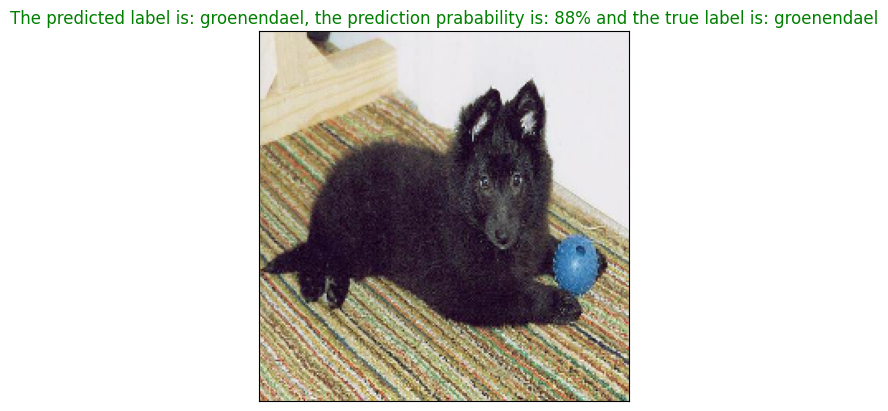

In [56]:
plot_pred(prediction_probabilities = predictions,
          labels = valid_labels,
          images = valid_images,
          n = 77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a ground truthb array and an integer
* Find the prediction using `get_pred_label()`
* Find the top 10:
    * Prediction Probabilities indexes
    * Prediction Probabilities values
    * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green

In [57]:
def plot_pred_conf(prediction_probabilities, labels, n = 1):
    """
    plot the top 10 highest prediction confidences along with the truth label for sample n.
    """
    
    pred_prob, true_label = prediction_probabilities[n], labels[n]
    
    # Get the predicted label
    pred_label = get_pred_label(pred_prob)
    
    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    
    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]
    
    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                       top_10_pred_values,
                       color = 'grey')
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels = top_10_pred_labels,
               rotation = 'vertical')
    
    # Change color of the true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass

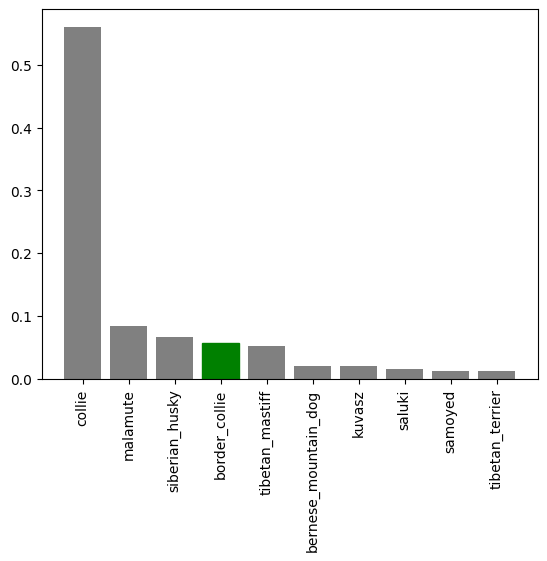

In [58]:
plot_pred_conf(prediction_probabilities = predictions,
               labels = valid_labels,
               n = 9)

Now we've got some functions to help us visualize our predictions and evaluate our model, let's check out a few.

In [59]:
def plot_pred_plus_conf(prediction_probabilities, labels, images, i_multiplier = 0):
    num_rows = 3
    num_cols = 2
    num_images = num_rows * num_cols
    plt.figure(figsize = (10 * num_cols, 5 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_pred(prediction_probabilities = prediction_probabilities,
                  labels = labels,
                  images = images,
                  n = i + i_multiplier)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_pred_conf(prediction_probabilities = prediction_probabilities,
                       labels = labels,
                       n = i + i_multiplier)

    plt.tight_layout(h_pad = 1.0)
    plt.show()

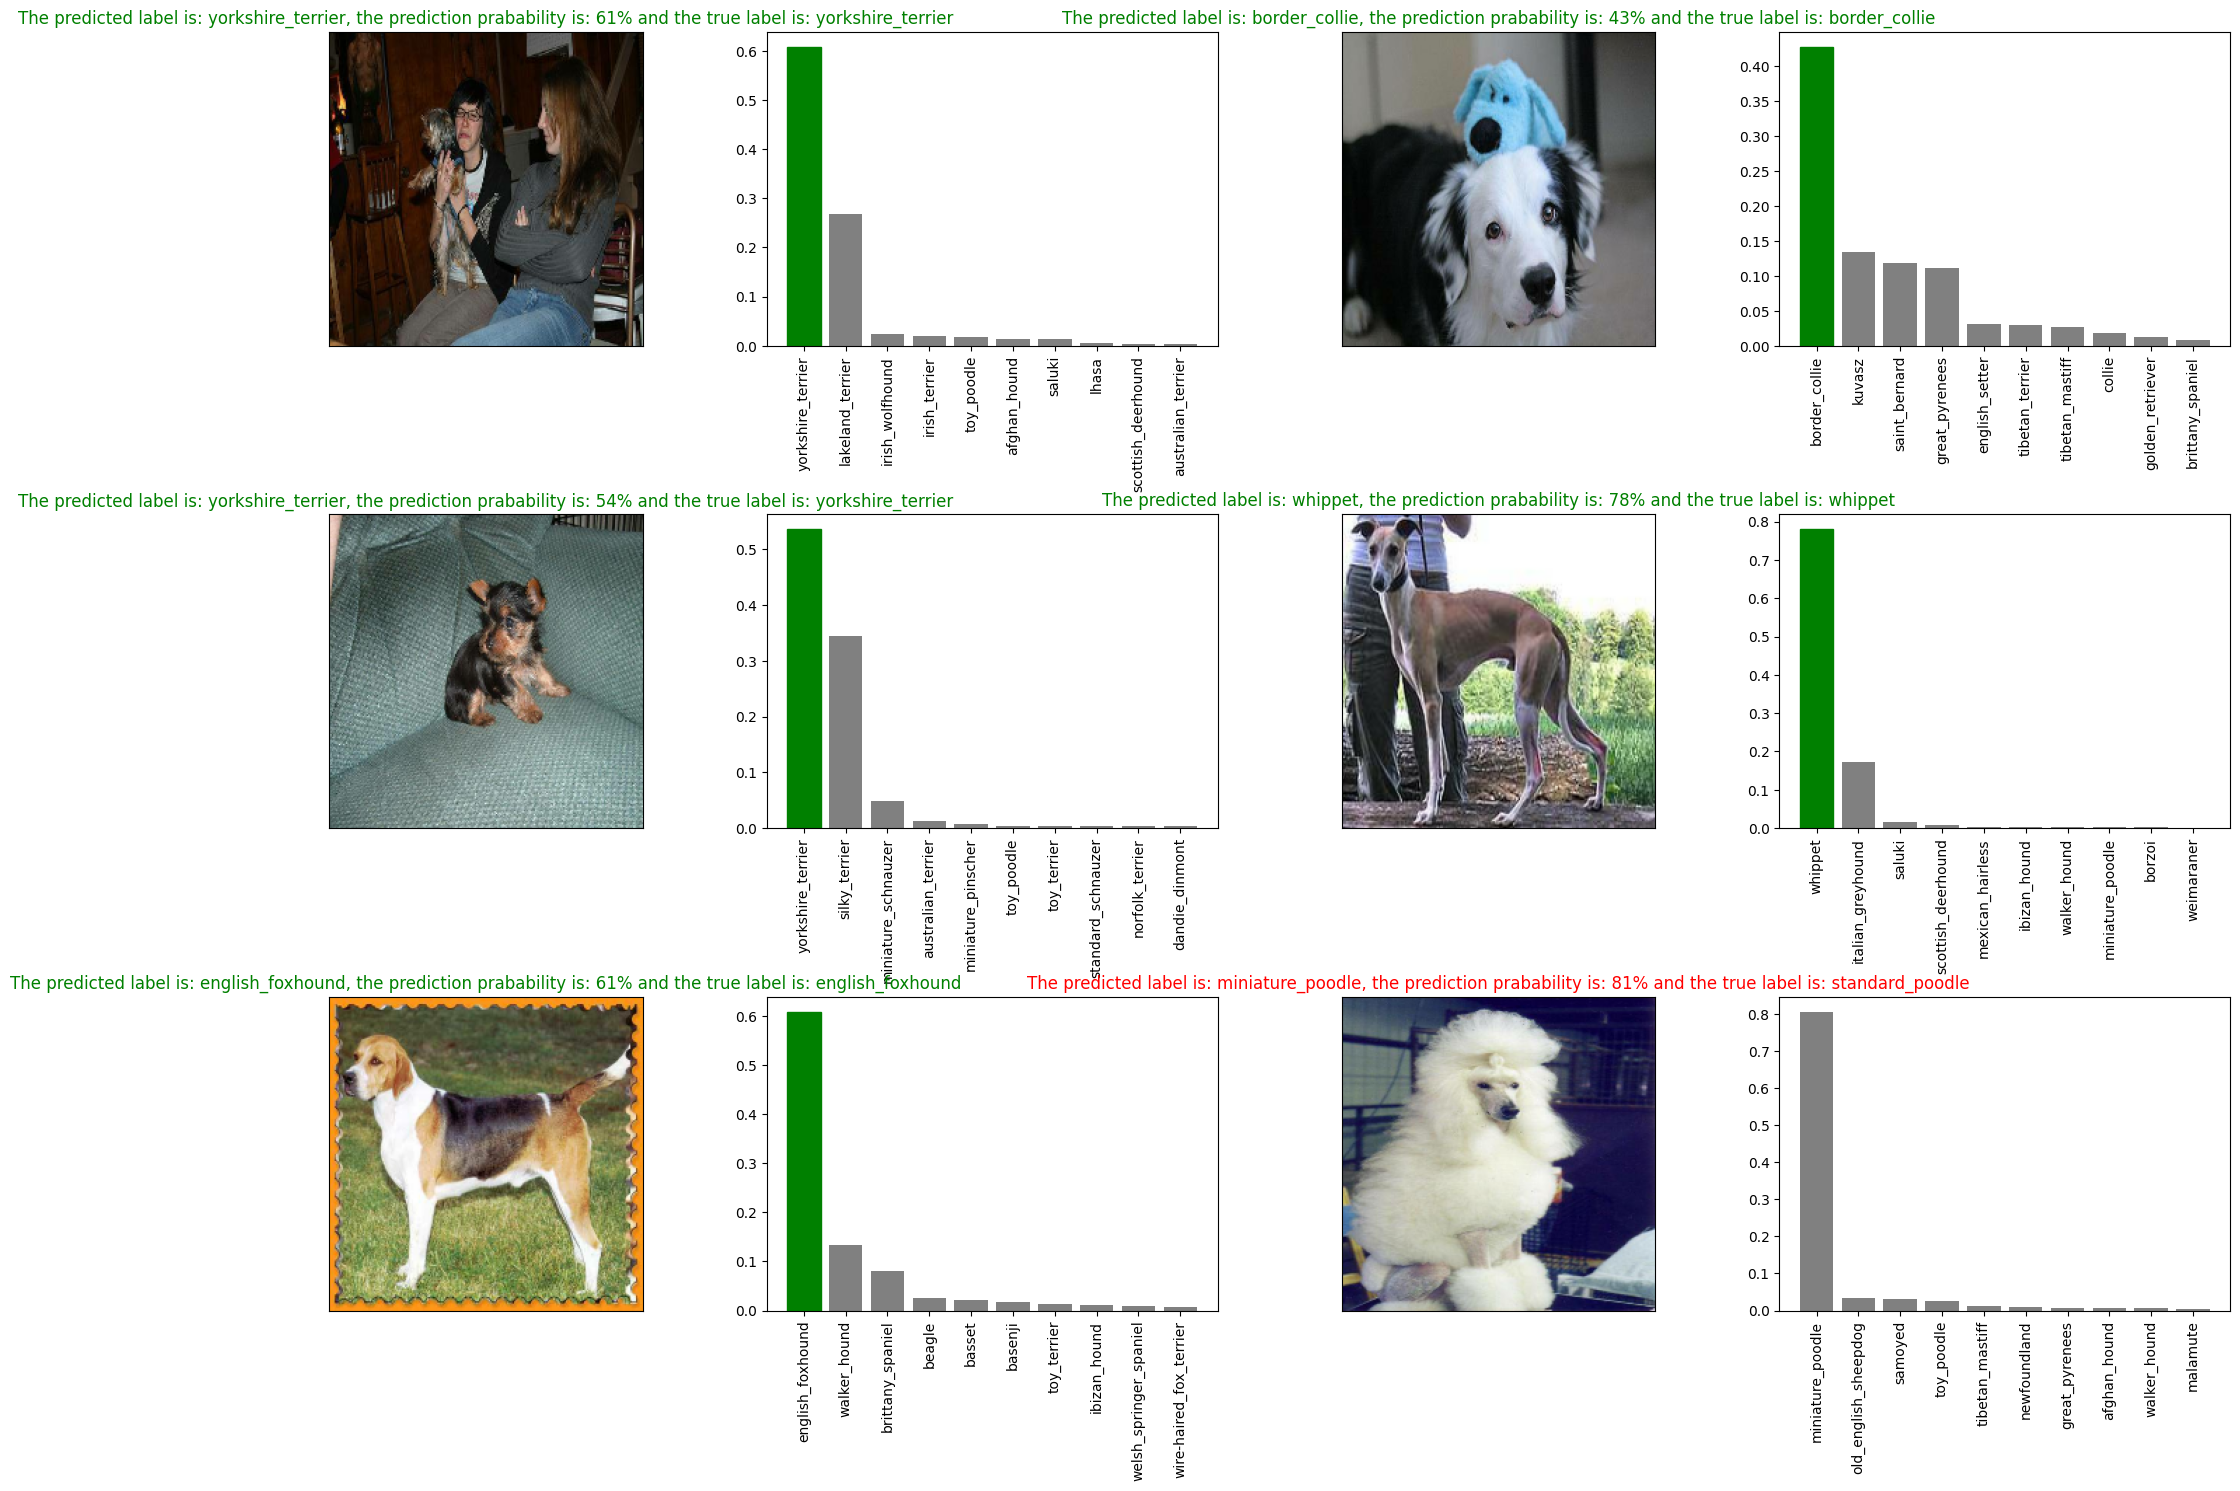

In [60]:
# Let's check out a few predictions and their different values
plot_pred_plus_conf(prediction_probabilities = predictions,
                    labels = valid_labels,
                    images = valid_images,
                    i_multiplier = 10)

In [61]:
# # Let's check out a few predictions and their different values
# i_multiplier = 10
# num_rows = 3
# num_cols = 2
# num_images = num_rows * num_cols
# plt.figure(figsize = (10 * num_cols, 5 * num_rows))
# for i in range(num_images):
#     plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
#     plot_pred(prediction_probabilities = predictions,
#               labels = valid_labels,
#               images = valid_images,
#               n = i + i_multiplier)
#     plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
#     plot_pred_conf(prediction_probabilities = predictions,
#                    labels = valid_labels,
#                    n = i + i_multiplier)

# plt.tight_layout(h_pad = 1.0)
# plt.show()

**Challenge:** How would you create a confusion matrix with our models predictions and true labels?

In [62]:
true_labels = []

for i in range(len(y_valid)):
    true_labels.append(y_valid[i].argmax())
    
true_labels = np.array(true_labels)
true_labels.size

200

In [63]:
predictions[0].argmax()

26

In [64]:
len(y_valid)

200

In [65]:
pred_labels = []

for i in range(len(predictions)):
    pred_labels.append(predictions[i].argmax())

pred_labels = np.array(pred_labels)
pred_labels.size

200

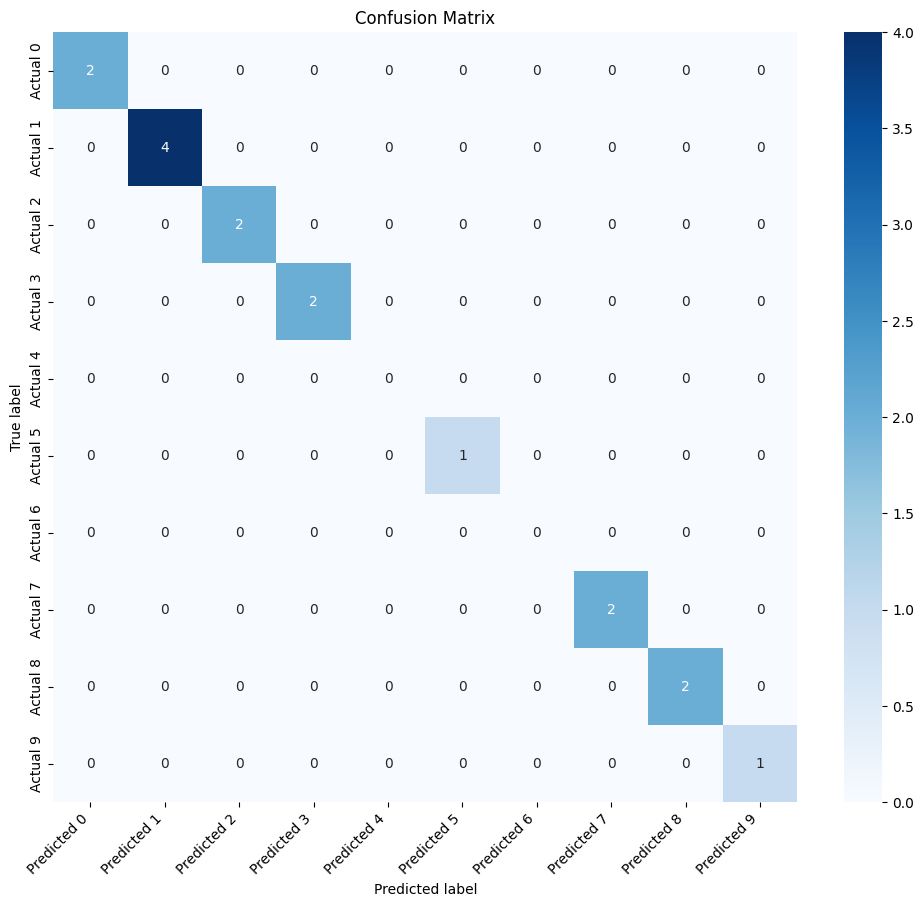

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

num_classes = 10

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=range(num_classes))

# Create a heatmap of the confusion matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=[f"Predicted {i}" for i in range(num_classes)],
            yticklabels=[f"Actual {i}" for i in range(num_classes)])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.show()

## Saving and reloading a trained model

In [67]:
# Create a function to save a model
def save_model(model, suffix = None):
    """
    Saves a given model in a models directory and appends a suffix (string).
    """
    # Create a model directory pathname with current time
    modeldir = os.path.join("models",
                            datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path = modeldir + "-" + suffix + ".h5" # Save format for model
    print(f'Saving model to: {model_path}...')
    model.save(model_path)
    return model_path

In [68]:
# create a function to load a trained model
def load_model(model_path):
    """
    Loads a saved model from a specified path.
    """
    print(f"Loading saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path,
                                      custom_objects = {"KerasLayer" : hub.KerasLayer})
    return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [69]:
# Save our model trained on 1000 images
save_model(model, suffix = '1000-images-mobilenetv2-Adam')

Saving model to: models/20230821-16441692632669-1000-images-mobilenetv2-Adam.h5...


/Users/samir/Library/CloudStorage/OneDrive-Personal/Desktop/SAMIR/Machine Learning/Complete Machine Learning & Data Science Bootcamp 2023/dog-vision-project/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'models/20230821-16441692632669-1000-images-mobilenetv2-Adam.h5'

In [70]:
# Load a trained model
loaded_1000_image_model = load_model('models/20230820-10201692523258-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: models/20230820-10201692523258-1000-images-mobilenetv2-Adam.h5


In [71]:
# Evaluate the pre-saved model
model.evaluate(valid_data)

7/7 [==============================] - 1s 113ms/step - loss: 1.1885 - accuracy: 0.7000


[1.1885154247283936, 0.699999988079071]

In [72]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(valid_data)

2023-08-21 16:44:32.504330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 2s 120ms/step - loss: 1.1857 - accuracy: 0.6950


[1.1857118606567383, 0.6949999928474426]

## Training a big dog model 🐶 (on the full data)

In [73]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)
full_data

Creating train data batches...


<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [74]:
# Create a model for full data
full_model = create_model()

BUilding model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [75]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',
                                                             patience = 3)

**Note:** Running the cell below will take a little while (maybe up to 30mins for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [76]:
# Fit the full model to the full data
full_model.fit(x = full_data,
               epochs = NUM_EPOCHS,
               callbacks = [full_model_tensorboard, full_model_early_stopping])

Epoch 1/100


2023-08-21 16:44:35.706687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


320/320 [==============================] - 26s 75ms/step - loss: 1.3442 - accuracy: 0.6701
Epoch 2/100
320/320 [==============================] - 24s 74ms/step - loss: 0.4027 - accuracy: 0.8823
Epoch 3/100
320/320 [==============================] - 24s 74ms/step - loss: 0.2355 - accuracy: 0.9354
Epoch 4/100
320/320 [==============================] - 23s 73ms/step - loss: 0.1522 - accuracy: 0.9636
Epoch 5/100
320/320 [==============================] - 24s 75ms/step - loss: 0.1075 - accuracy: 0.9773
Epoch 6/100
320/320 [==============================] - 26s 80ms/step - loss: 0.0774 - accuracy: 0.9866
Epoch 7/100
320/320 [==============================] - 25s 79ms/step - loss: 0.0576 - accuracy: 0.9924
Epoch 8/100
320/320 [==============================] - 25s 79ms/step - loss: 0.0460 - accuracy: 0.9948
Epoch 9/100
320/320 [==============================] - 25s 78ms/step - loss: 0.0367 - accuracy: 0.9963
Epoch 10/100
320/320 [==============================] - 26s 82ms/step - loss: 0.0312 

In [77]:
save_model(full_model, suffix = 'full-image-set-mobilenetv2-Adam')

Saving model to: models/20230821-16531692633204-full-image-set-mobilenetv2-Adam.h5...


'models/20230821-16531692633204-full-image-set-mobilenetv2-Adam.h5'

In [78]:
# Load in the full model
loaded_full_model = load_model('models/20230820-13161692533778-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: models/20230820-13161692533778-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels).
* Make a predictions array by passing the test data batches to the `predict()` method called on our model.

In [79]:
# Load test image filenames
test_path = "data/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['data/test/266490a2b053a4a3bf68e779f28fb5a9.jpg',
 'data/test/dae9fd18836d8df20989ef0101771d4b.jpg',
 'data/test/079a40f22b0fad9a66f76797b62bb930.jpg',
 'data/test/ab8462f9a501d362041d47582fddc9ad.jpg',
 'data/test/8895089b432e020cc42e6262b5a1c2dd.jpg',
 'data/test/985ae7fc271ac4a0d131e546c0f95bb6.jpg',
 'data/test/77c1ab99cffb817d54fb14f229aeb118.jpg',
 'data/test/ad7e50abca9b7c6a88b63946c5bbe493.jpg',
 'data/test/d61a09cecf56666cdb315ebce4b93c43.jpg',
 'data/test/cb120c57904e8c0694bbe259c58a873c.jpg']

In [80]:
len(test_filenames)

10357

In [81]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data = True)

Creating test data batches...


In [82]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run (about ~1hr).

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose = 1)

2023-08-21 16:53:26.834393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


225/324 [===================>..........] - ETA: 6s

In [ ]:
# Save predictions (Numpy array) to csv file (for access later)
np.savetxt('preds_array.csv', test_predictions, delimiter = ',')

In [ ]:
# Load predictions (Numpy array) from csv file
loaded_test_predictions = np.loadtxt('preds_array.csv', delimiter = ',')

In [ ]:
loaded_test_predictions

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID column and a column for each different dog breed. https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID Column as well as a coluymn for each dog breed.
* Add data to the ID Column by extracting the test image ID's from their filepaths
* Add data (the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns = ['id'] + list(unique_breeds))
preds_df.head()

In [ ]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [ ]:
preds_df.head()

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

In [ ]:
# Save our predictions DataFrame to CSV for submission to Kaggle
preds_df.to_csv('full_model_predictions_submission_1_mobilenetv2.csv',
                index = False)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the test data parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.

In [ ]:
# Get custom image filepaths
custom_path = 'dog-photos/'
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths

In [ ]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data = True)
custom_data

In [ ]:
# Make predictions on the custom data
custom_preds = full_model.predict(custom_data)